# Importing necessary libraries and modules.

In [ ]:
# Data processing
import numpy as np
import pandas as pd

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras

# Keras layers and callbacks
from keras import layers
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Image processing
from keras.preprocessing.image import ImageDataGenerator
import cv2

# Files
import tarfile
import io

# OS functions
import os

# Visualization
import matplotlib.pyplot as plt

# Mounting the Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Extracting and loading the dataset.

In [ ]:
# Open the .tar.gz file containing the fer2013 dataset
with tarfile.open('/content/drive/MyDrive/EMOSENSE/fer2013.tar.gz', 'r:gz') as tar:
    # Extract the .csv file from the .tar.gz file
    csv_file = tar.extractfile('fer2013/fer2013.csv')

    # Read the extracted .csv file into a pandas DataFrame
    data = pd.read_csv(io.StringIO(csv_file.read().decode('utf-8')))

In [ ]:
# Display the first few rows of the DataFrame to verify the data is loaded correctly
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
# Count the frequency of each unique emotion label in the "emotion" column
data["emotion"].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [ ]:
# Count the frequency of each unique usage category in the "Usage" column
data["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

# Data Visualization.

<ipython-input-6-1dd931bac9c5>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(2, len(classes), len(classes) + i + 1)


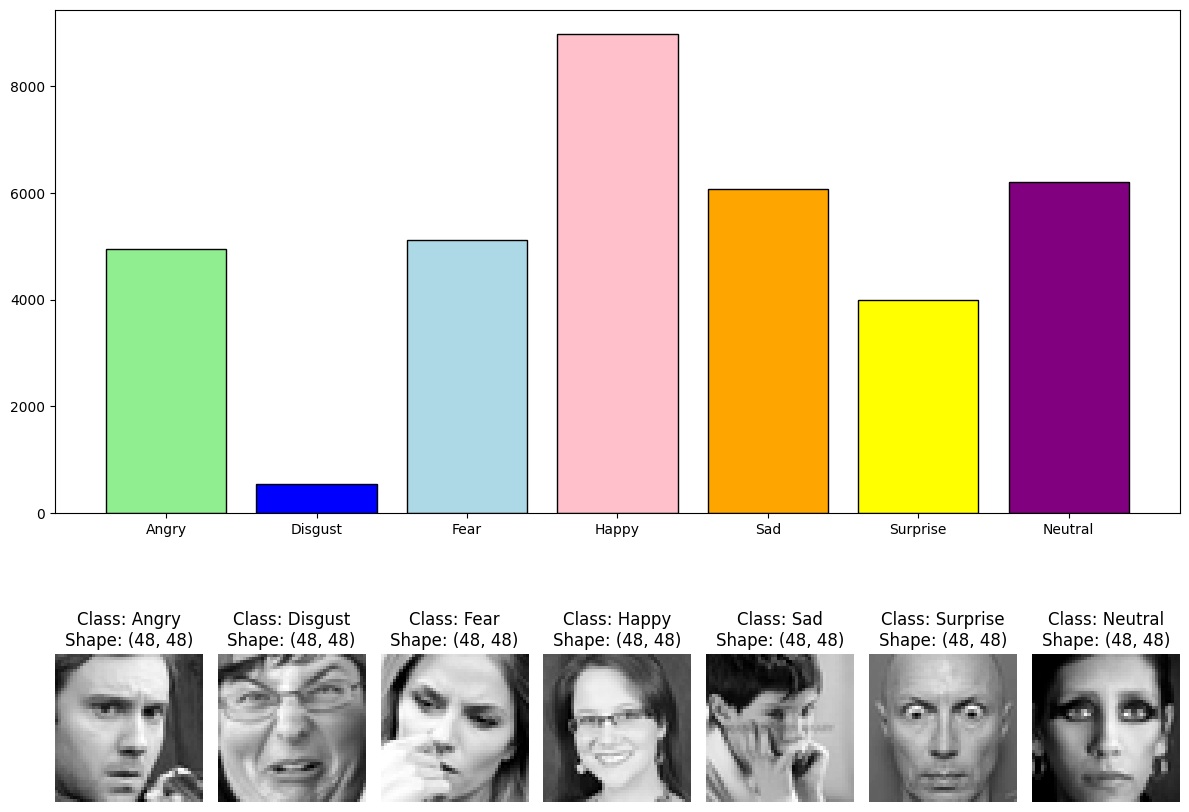

In [ ]:
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

def plot_data(data, classes):
    # Calculate the frequency count of each emotion label in the dataset
    values = data["emotion"].value_counts().sort_index(ascending=True)

    # Specify colors for each emotion class in the bar chart
    colors = ["lightgreen", "blue", "lightblue", "pink", "orange", "yellow", "purple"]

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot the bar chart on the top subplot
    ax1.bar(x=classes, height=values, color=colors, edgecolor='black')

    # Plot one sample image from each class on the bottom subplot
    for i, emotion in enumerate(classes):
        # Select the first data sample for the current emotion class
        sample_image = data[data["emotion"] == i].iloc[0]

        # Extract and convert the pixel values to a NumPy array
        pixels = np.array(list(map(int, sample_image["pixels"].split())))

        # Reshape the pixel array into a 2D image
        image = pixels.reshape(48, 48)

        # Create a subplot for displaying the image
        ax2 = plt.subplot(2, len(classes), len(classes) + i + 1)

        # Display the image on the subplot with a grayscale color map
        ax2.imshow(image, cmap='gray')

        # Set the title of the subplot with the emotion class name and image shape
        ax2.set_title(f"Class: {emotion}\nShape: {image.shape}")

        # Hide axis labels and ticks for the subplot
        ax2.axis('off')

    # Adjust the subplot layout to prevent overlap
    plt.tight_layout()

    # Display the figure
    plt.show()

# Call the function to visualize the data
plot_data(data, class_names)

# Removing Angry, Disgust, Fear, Surprise, and Neutral emotion classes

In [ ]:
# Filter out specific emotion classes from the dataset
data = data[data["emotion"] != 0]
data = data[data["emotion"] != 1]
data = data[data["emotion"] != 2]
data = data[data["emotion"] != 5]
data = data[data["emotion"] != 6]

# Reset the index and update the emotion value counts
data["emotion"].value_counts().reset_index(drop=True, inplace=True)

# Data Split and Concatenation

In [ ]:
# Split the data into feature matrix X and target variable y
X = data.drop("emotion", axis=1)
y = data["emotion"]

# Concatenate the feature matrix X and target variable y into a new DataFrame
df = pd.concat([X, y], axis=1)

In [ ]:
# Count the occurrences of each emotion in the 'emotion' column of the DataFrame
emotion_counts = df["emotion"].value_counts()

3    8989
4    6077
Name: emotion, dtype: int64

# Image Processing

In [ ]:
# Function to convert pixel values to a NumPy array
def pixels_to_array(pixels):
    array = np.array(pixels.split(), 'float64')
    return array

# Function to reshape image data
def image_reshape(data):
    # Reshape the data to a 4D array with dimensions (num_samples, height, width, channels)
    image = np.reshape(data.to_list(), (data.shape[0], 48, 48, 1))

    # Repeat the grayscale image along the channel axis to create a 3-channel image
    image = np.repeat(image, 3, -1)

    return image

In [ ]:
# Apply the 'pixels_to_array' function to convert pixel values in the 'pixels' column
df['pixels'] = df['pixels'].apply(pixels_to_array)

# Data Split into Training and Test Sets.

In [ ]:
# Split the data into training, public test, and private test sets based on the 'Usage' column
data_train = df[df["Usage"] == "Training"]
data_test1 = df[df["Usage"] == "PublicTest"]
data_test2 = df[df["Usage"] == "PrivateTest"]

# Concatenate the public and private test sets into a single test set
data_test = pd.concat([data_test1, data_test2])

In [ ]:
# Reshape the pixel data of the training set
X_train = image_reshape(data_train["pixels"])

# Reshape the pixel data of the test set
X_test = image_reshape(data_test["pixels"])

# Assign the emotion labels of the training set
y_train = data_train["emotion"]

# Assign the emotion labels of the test set
y_test = data_test["emotion"]

# Directory Creation for Data Storage.

In [ ]:
# Create a directory named 'data'
!mkdir data

# Create a subdirectory named 'train' within the 'data' directory
!mkdir data/train

# Create a subdirectory named 'test' within the 'data' directory
!mkdir data/test

In [ ]:
# Reset the index of the training set target labels
y_train.reset_index(drop=True, inplace=True)

# Reset the index of the test set target labels
y_test.reset_index(drop=True, inplace=True)

In [ ]:
# Replace specific values in the training set target labels
y_train = y_train.replace({3: 1, 4: 2})

# Replace specific values in the test set target labels
y_test = y_test.replace({3: 1, 4: 2})

In [ ]:
def put_in_dir(X_train, X_test, y_train, y_test, classes):
    # Create directories for each class in the training and test sets
    for label in range(len(classes)):
        os.makedirs("/content/data/train/" + classes[label], exist_ok=True)
        os.makedirs("/content/data/test/" + classes[label], exist_ok=True)

    # Store training images in the appropriate directories
    for i in range(len(X_train)):
        # Retrieve the emotion label for the current image
        emotion = classes[y_train[i]]
        # Save the image to the corresponding directory with a filename that includes the emotion label and index
        cv2.imwrite(f"/content/data/train/{emotion}/{emotion}{i}.png", X_train[i])

    # Store test images in the appropriate directories
    for j in range(len(X_test)):
        # Retrieve the emotion label for the current image
        emotion = classes[y_test[j]]
        # Save the image to the corresponding directory with a filename that includes the emotion label and index
        cv2.imwrite(f"/content/data/test/{emotion}/{emotion}{j}.png", X_test[j])

In [ ]:
class_names = ["Happy", "Sad"]

# Map the emotion labels to the class indices
label_mapping = {3: 0, 4: 1}
y_train_mapped = y_train.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

# Check for and handle missing or invalid values
y_train_mapped = y_train_mapped.replace({np.nan: 0, np.inf: 0})
y_test_mapped = y_test_mapped.replace({np.nan: 0, np.inf: 0})

# Convert mapped labels to integers
y_train_int = y_train_mapped.astype(int)
y_test_int = y_test_mapped.astype(int)

put_in_dir(X_train, X_test, y_train_int, y_test_int, class_names)

# Data Preprocessing and Augmentation.

In [ ]:
# Define the desired shape of the input images
IMAGE_SHAPE = (48, 48)

# Define the batch size for training and evaluation
BATCH_SIZE = 64

# Define the directory paths for the training and test sets
train_dir = "/content/data/train/"
test_dir = "/content/data/test/"

# Create an ImageDataGenerator for training data with data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=0.1,
                                   zoom_range=0.1)

# Create an ImageDataGenerator for test data without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

# Generate a flow of training data from the directory
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical",
                                               shuffle=True)

# Generate a flow of test data from the directory
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Found 12045 images belonging to 2 classes.
Found 3021 images belonging to 2 classes.


# Convolutional Neural Network (CNN) model training.

In [ ]:
num_classes = 2

# Define your model
model = keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks (e.g., reduce_lr, checkpoint_callback)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True)

# Fit the model
model.fit(train_data, epochs=10, callbacks=[reduce_lr, checkpoint_callback], validation_data=test_data)

Epoch 1/80
189/189 [==============================] - 31s 98ms/step - loss: 0.0043 - accuracy: 0.9979 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/80
189/189 [==============================] - 16s 83ms/step - loss: 8.9375e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/80
189/189 [==============================] - 16s 84ms/step - loss: 0.0026 - accuracy: 0.9997 - val_loss: 4.1485e-04 - val_accuracy: 0.9997 - lr: 0.0010
Epoch 4/80
189/189 [==============================] - 16s 83ms/step - loss: 3.5018e-05 - accuracy: 1.0000 - val_loss: 3.9460e-11 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/80
189/189 [==============================] - 16s 83ms/step - loss: 8.5562e-06 - accuracy: 1.0000 - val_loss: 9.0758e-10 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/80
189/189 [==============================] - 18s 94ms/step - loss: 2.6960e-04 - accuracy: 0.9999 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/80
189/189 [==============================] - 16s 83ms/step - loss: 1.0153e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 8/80
189

# TensorFlow Lite Conversion, Model Evaluation, and Metrics Calculation.

TensorFlow Lite model saved to: /content/drive/MyDrive/EMOSENSE/model.tflite
48/48 [==============================] - 2s 34ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test Loss: 0.0000
Test Accuracy: 1.0000
48/48 [==============================] - 1s 23ms/step


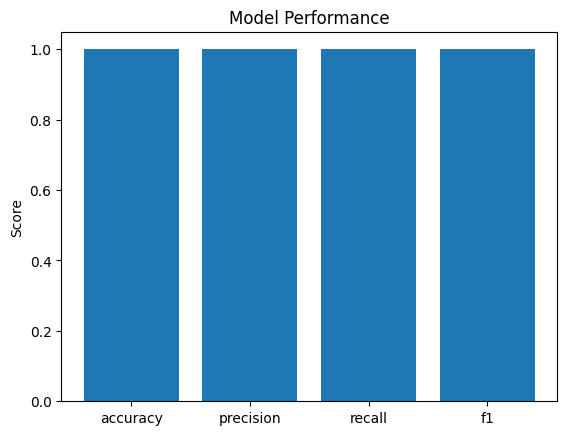

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


In [ ]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
tflite_model_path = '/content/drive/MyDrive/EMOSENSE/model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Print the file path
print(f"TensorFlow Lite model saved to: {tflite_model_path}")

# Load saved model
model = tf.keras.models.load_model('model.h5')

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_data)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Predictions
test_predictions = model.predict(test_data)
test_predictions = np.argmax(test_predictions, axis=1)

# True labels
test_true_labels = y_test_int

# Calculate evaluation metrics
metrics = {
    'accuracy': accuracy_score(test_true_labels, test_predictions),
    'precision': precision_score(test_true_labels, test_predictions, average='macro'),
    'recall': recall_score(test_true_labels, test_predictions, average='macro'),
    'f1': f1_score(test_true_labels, test_predictions, average='macro')
}

# Plot the metrics
plt.bar(metrics.keys(), metrics.values())
plt.ylabel('Score')
plt.title('Model Performance')
plt.show()

# Print the metrics
print(metrics)